In [1]:
import os

import pandas as pd
import numpy as np
import itertools
import geopandas as gpd

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
from matplotlib.lines import Line2D
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.transforms import ScaledTranslation

plt.rcParams['legend.handlelength'] = 1
plt.rcParams['legend.handleheight'] = 1.125
plt.rcParams["font.family"]         = "Avenir"

path_to_scenarios = '/Users/Guille/Desktop/india_power/scenarios'
path_to_images    = '/Users/Guille/Desktop/india_power/images'
path_to_csvs      = '/Users/Guille/Desktop/india_power/gridpath_india_viz/csvs'

In [2]:
# Grab data from databases for plotting LCOE emissions
def _load_cost(scen_labels_):
    # Load fuel, and operation and maintanace cost table and process data from database
    def __load_vr_cost_from_csv(df_, scenario):
        
        df_['variable_om_cost'] = df_['number_of_hours_in_timepoint']*df_['timepoint_weight']*df_['variable_om_cost']
         
        df_ = df_[['period', 'technology', 'load_zone', 'variable_om_cost']]
        df_ = df_.rename(columns = {'variable_om_cost': 'variable_cost'})
        df_ = df_.groupby(['period', 
                           'technology',
                           'load_zone']).sum().reset_index(drop = False)
                         
        df_['scenario'] = scenario     

        return df_

    # Load fix capacity cost table and process data from database
    def __load_fx_cost_from_csv(project_, new_, spec_, scenario):
        
        new_ = new_.fillna({'capacity_cost': 0, 'fixed_cost': 0})
        
        new_['fixed_cost'] = new_['capacity_cost'] + new_['fixed_cost']

        new_ = new_[['period', 'technology', 'load_zone', 'fixed_cost']]
        new_ = new_.groupby(['period', 
                             'technology', 
                             'load_zone']).sum().reset_index(drop = False)
                             
        spec_['fixed_cost'] = spec_['fixed_cost_per_mw_yr'] 

        spec_ = pd.merge(spec_, project_, on = ['project'])
        spec_ = spec_[['period', 'technology', 'load_zone', 'fixed_cost']]
        spec_ = spec_.groupby(['period', 
                               'technology', 
                               'load_zone']).sum().reset_index(drop = False)

        df_ = pd.concat([new_, spec_], axis = 0)
        df_ = df_.groupby(['period', 
                           'technology',
                           'load_zone']).sum().reset_index(drop = False)
        
        df_['scenario'] = scenario    

        return df_

    # Load transmission capacity cost table and process data from database
    def __load_tx_cost_from_csv(project_, new_, scenario):

        new_['fixed_cost'] = new_['capacity_cost'] + new_['fixed_cost']
        
        new_ = new_[['period', 'transmission_line', 'max_mw', 'fixed_cost']]
        new_ = new_.rename(columns = {'max_mw': 'power_mw'})
        df_  = new_.groupby(['period', 
                             'transmission_line']).sum().reset_index(drop = False)
        project_ = project_.loc[project_['vintage'] == 2020].reset_index(drop = False)
        project_ = project_[['transmission_line', 'tx_annualized_real_cost_per_mw_yr']]
        
#         project_p_                      = project_.copy()
#         project_p_['transmission_line'] = project_p_['transmission_line'].str.replace('_new', '')
#         project_ = pd.concat([project_, project_p_], axis = 0).reset_index(drop = True)

        df_                  = pd.merge(df_, project_, on = ['transmission_line'])
        df_['capacity_cost'] = df_['tx_annualized_real_cost_per_mw_yr']*df_['power_mw']
        df_['load_zone']     = df_['transmission_line'].apply(lambda x: x.split("-")[0])
        df_                  = df_[['period', 'load_zone', 'capacity_cost', 'fixed_cost']]
        df_                  = df_.groupby(['period', 
                                            'load_zone']).agg({'capacity_cost': 'sum', 
                                                               'fixed_cost': 'sum'}).reset_index(drop = False)
        df_['fixed_cost']    = df_['capacity_cost'] + df_['fixed_cost']
        df_['variable_cost'] = 0.
        df_                  = df_[['period', 'load_zone', 'fixed_cost', 'variable_cost']]
        df_['technology']    = 'Transmission Losses'    
        df_['scenario']      = scenario    
        
        return df_

    # Load energy dispatch table and process data from database
    def __load_demand_from_csv(df_, scenario):
        
        df_['static_load_mw'] = df_['number_of_hours_in_timepoint']*df_['timepoint_weight']*df_['static_load_mw']

        df_ = df_[['period', 'load_zone', 'static_load_mw']]
        df_ = df_.groupby(['period', 
                           'load_zone']).sum().reset_index(drop = False)
                         
        df_['technology'] = 'Demand'     
        df_['scenario']   = scenario     

        return df_.rename(columns = {'static_load_mw': 'load_mw'})

    dfs_1_ = []
    dfs_2_ = []
    # Open connection: open database and grab meta-data
    for scen, path in zip(scen_labels_['scenario'], scen_labels_['path']):
        print(scen, path)
        dir_name = r'{}/{}'.format(path, scen)        

        # Load energy demand from csv files
        load_ = pd.read_csv(dir_name + f'/results/system_load_zone_timepoint.csv', low_memory = False)
        load_ = __load_demand_from_csv(load_, scen)
        
        # Load fix costs from csv files
        new_     = pd.read_csv(dir_name + f'/results/project_period.csv', low_memory = False)
        spec_    = pd.read_csv(dir_name + r'/inputs/spec_capacity_period_params.tab', sep = '\t', engine = 'python')
        project_ = pd.read_csv(dir_name + r'/inputs/projects.tab', sep = '\t', engine = 'python')
        fx_      = __load_fx_cost_from_csv(project_, new_, spec_, scen)
        
        # Load variables costs from csv files
        vr_ = pd.read_csv(dir_name + f'/results/project_timepoint.csv', low_memory = False)
        vr_ = __load_vr_cost_from_csv(vr_, scen)
        
        # Load tx costs from csv files
        new_     = pd.read_csv(dir_name + f'/results/transmission_period.csv', low_memory = False) 
        spec_    = pd.read_csv(dir_name + r'/inputs/specified_transmission_line_capacities.tab', sep = '\t', engine = 'python')        
        project_ = pd.read_csv(dir_name + r'/inputs/new_build_transmission_vintage_costs.tab', sep = '\t', engine = 'python')
        tx_      = __load_tx_cost_from_csv(project_, new_, scen)

        df_ = pd.merge(vr_, fx_, on = ['scenario', 'technology', 'period', 'load_zone'])
        df_ = pd.concat([df_, tx_], axis = 0)

        dfs_1_.append(df_)
        dfs_2_.append(load_)

    df_1_ = pd.concat(dfs_1_, axis = 0).reset_index(drop = True)
    df_2_ = pd.concat(dfs_2_, axis = 0).reset_index(drop = True)

    df_1_['period']        = df_1_['period'].astype(int)
    df_1_['fixed_cost']    = df_1_['fixed_cost'].astype(float)
    df_1_['variable_cost'] = df_1_['variable_cost'].astype(float)
    
    df_2_['period']  = df_2_['period'].astype(int)
    df_2_['load_mw'] = df_2_['load_mw'].astype(float)

    return df_1_, df_2_

In [3]:
def _group_tech_cost_by_tech(df_1_, df_2_, scen_labels_):

    columns_ = ['period', 'technology', 'scenario', 'load_zone']
    
    dfs_1_ = []
    dfs_2_ = []
    # Open connection: open database and grab meta-data
    for scen, zone in zip(scen_labels_['scenario'], scen_labels_['zone']):
        
        df_1_p_ = df_1_.loc[df_1_['scenario'] == scen].copy()
        df_2_p_ = df_2_.loc[df_2_['scenario'] == scen].copy()

        idx_1_ = df_1_p_['load_zone'] == zone
        idx_2_ = df_2_p_['load_zone'] == zone

        if idx_1_.sum() == 0.:
            df_1_p_['load_zone'] = 'all'
            df_2_p_['load_zone'] = 'all'
        else:
            df_1_p_ = df_1_p_.loc[idx_].reset_index(drop = True)
            df_2_p_ = df_2_p_.loc[idx_].reset_index(drop = True)

        dfs_1_.append(df_1_p_.groupby(columns_).sum().reset_index(drop = False))
        dfs_2_.append(df_2_p_.groupby(columns_).sum().reset_index(drop = False))

    df_1_ = pd.concat(dfs_1_, axis = 0).reset_index(drop = True)
    df_2_ = pd.concat(dfs_2_, axis = 0).reset_index(drop = True)

    df_1_['period']        = df_1_['period'].astype(int)
    df_1_['fixed_cost']    = df_1_['fixed_cost'].astype(float)
    df_1_['variable_cost'] = df_1_['variable_cost'].astype(float)

    df_2_['period']  = df_2_['period'].astype(int)
    df_2_['load_mw'] = df_2_['load_mw'].astype(float)
    
    return df_1_, df_2_

def _group_cost_technologies(df_, tech_labels_):

    for group in tech_labels_['group'].unique():
        df_.loc[df_['technology'].isin(tech_labels_.loc[tech_labels_['group'] == group, 'technology']), 'technology'] = group
        
    df_ = df_.groupby(['period', 
                       'technology', 
                       'load_zone', 
                       'scenario']).agg({'variable_cost': 'sum', 
                                         'fixed_cost': 'sum'})

    return df_.reset_index(drop = False)

In [4]:
def _plot_levelized_fixed_and_variable_cost(axp, df_1_, df_2_, scens_label_, tech_label_,
                                            USD_to_INR   = 72,
                                            y_lim_max    = 70,
                                            units        = 1,
                                            ylabel       = '',
                                            yplabel      = '',
                                            y_period_loc = -38,
                                            y_grid_inc   = 10,
                                            div_line_len = 0.49,
                                            legend       = True,
                                            title        = ''):
    
    y_period_loc = y_period_loc*y_lim_max

    def __make_fixed_and_variable_cost_legend(ax, df_, techs_):
        
        tech_idx_ = np.sort(np.unique(techs_['order']))

        ax.bar(0., 0., 0., bottom    = 0.,
                           label     = 'Variable Costs',
                           color     = 'None',
                           lw        = 0.,
                           hatch     = 'xx',
                           edgecolor = 'lightgray',
                           zorder    = 10)

        for i_tech in tech_idx_:
            tech  = tech_label_.loc[tech_label_['order'] == i_tech, 'group'].unique()[0]
            color = tech_label_.loc[tech_label_['order'] == i_tech, 'group_color'].unique()[0]
            
            idx_ = df_['technology'] == tech
            
            if idx_.sum() > 0:
                if df_.loc[idx_, 'fixed_cost'].sum() != 0:
                    ax.bar(0., 0., 0., bottom = 0.,
                                       color  = color,
                                       label  = tech.replace('Transmission Losses', 'Transmission'),
                                       zorder = 10)

    periods_  = np.sort(df_1_['period'].unique())
    scens_    = scens_label_['scenario'].unique()    
    tech_idx_ = np.sort(np.unique(tech_label_['order']))

    ticks_    = []
    labels_   = []
    offsets_  = []
    lengths_  = []
    x_period_ = []
    
    i_scen = 0
    offset = 0
    y_max  = 0
    
    width  = 1/(len(scens_) + 1.5)
    x_     = np.linspace(0, len(periods_) - 1, len(periods_))
    
    ax = axp.twinx()

    for scen, label in zip(scens_label_['scenario'], scens_label_['label']):

        df_p_ = df_1_.copy()
            
        for period, i_period in zip(periods_, range(len(periods_))):
            idx_1_ = (df_p_['scenario'] == scen)  & (df_p_['period'] == period)
            if (i_scen == 0) & (i_period == 0): 
                __make_fixed_and_variable_cost_legend(ax, df_p_, tech_label_)
            
            z = df_2_.loc[(df_2_['scenario'] == scen)  & (df_2_['period'] == period), 'load_mw'].to_numpy()[0]

            for i_tech in tech_idx_:
                
                tech  = tech_label_.loc[tech_label_['order'] == i_tech, 'group'].unique()[0]
                color = tech_label_.loc[tech_label_['order'] == i_tech, 'group_color'].unique()[0]  
                
                idx_2_ = idx_1_ & (df_p_['technology'] == tech)

                if idx_2_.sum() == 1.:
                    y = df_p_.loc[idx_2_, 'variable_cost'].to_numpy()[0]

                    ax.bar(x_[i_period], (y/z)/units, width, 
                           bottom    = offset/units,
                           color     = color,
                           lw        = 0.,
                           hatch     = 'x',
                           edgecolor = 'lightgray', 
                           zorder    = 10)

                    offset += y/z

            for i_tech in tech_idx_:
                
                tech  = tech_label_.loc[tech_label_['order'] == i_tech, 'group'].unique()[0]
                color = tech_label_.loc[tech_label_['order'] == i_tech, 'group_color'].unique()[0]  
                
                idx_3_ = idx_1_ & (df_p_['technology'] == tech)
                
                if idx_3_.sum() == 1.:
                    y = df_p_.loc[idx_3_, 'fixed_cost'].to_numpy()[0]
                    #c = tech_label_.loc[tech_label_['group'] == tech, 'group_color'].unique()

                    ax.bar(x_[i_period], (y/z)/units, width, 
                           bottom = offset/units,
                           color  = color,
                           zorder = 10)

                    offset += y/z

            if y_max < offset:
                y_max = offset

            ticks_.append(x_[i_period])
            labels_.append(label)
            offsets_.append(offset/units)
            x_period_.append(x_[i_period])

            offset = 0.

        x_ = x_ + .9/len(scens_)
        i_scen += 1
        
    z_ = x_ - .9/len(scens_)

    x_period_ = np.mean(np.array(x_period_).reshape(len(scens_), len(periods_)), axis = 0)
    y_period_ = np.max(np.array(offsets_).reshape(len(scens_), len(periods_)), axis = 0)
    
    for x_period, y_period, period in zip(x_period_, y_period_, periods_):
        ax.text(x_period, y_period_loc, period, fontsize            = 18, 
                                                weight              = 'bold',
                                                horizontalalignment = 'center', 
                                                verticalalignment   = 'center')

    x_ = np.linspace(0, len(periods_), len(periods_) + 1)
    dz = (x_[1] - z_[0])
    for x in x_:
        ax.axvline(x - dz/2., ymin      = 0.,
                              ymax      = - div_line_len,
                              linewidth = .75,
                              linestyle = '-',
                              color     = 'k',
                              clip_on   = False,
                              zorder    = 10)

    axp.set_xticks(ticks_, labels_, fontsize = 14, rotation = 90)

    ax.xaxis.set_tick_params(labelsize = 14, left = False)
    axp.xaxis.set_tick_params(labelsize = 14, left = False)

    axp.yaxis.set_tick_params(labelsize = 14, right = False, left = False)
    ax.yaxis.set_tick_params(labelsize = 14, right = False, left = False)
    
    axp.set_ylabel(ylabel, fontsize = 18)
    ax.set_ylabel(yplabel, fontsize = 18)

    if legend:
        ax.legend(bbox_to_anchor = (1.1, 0.925),
                  frameon        = False,
                  prop           = {'size': 14})


    N_steps  = int(np.ceil((y_max/units)/y_grid_inc))
    y_ticks_ = np.linspace(0, int(N_steps*y_grid_inc), N_steps + 1, dtype = int)
    yp_ticks_ = np.array([0, 1, 2, 3, 4, 5])

    axp.set_yticks(y_ticks_, y_ticks_)
    ax.set_yticks(yp_ticks_*1000/USD_to_INR, yp_ticks_)
    
    axp.set_ylim(-.2, y_lim_max)
    
    #ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
    #axp.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))

    ax.set_title(title, fontsize = 20,
                        y        = 0.912)

    ax.spines[['right', 'top', 'left', 'bottom']].set_visible(False)
    axp.spines[['right', 'top', 'left', 'bottom']].set_visible(False)

    axp.grid(axis = 'y', lw = .66)
    ax.grid(axis = 'y', linestyle = '-.', lw = .33)

def _plot_total_fixed_and_variable_cost(axp, df_, scens_label_, tech_label_, 
                                        USD_to_INR   = 72,
                                        y_lim_max    = 400,
                                        units        = 1e9,
                                        ylabel       = 'System Costs (Billion USD)',
                                        yplabel      = '',
                                        y_period_loc = -217.5,
                                        y_grid_inc   = 50,
                                        div_line_len = 0.5,
                                        legend       = True,
                                        title        = ''):

    y_period_loc = y_period_loc*y_lim_max

    def __make_fixed_and_variable_cost_legend(ax, df_, techs_):
        
        tech_idx_ = np.sort(np.unique(techs_['order']))

        ax.bar(0., 0., 0., bottom    = 0.,
                           label     = 'Variable Costs',
                           color     = 'None',
                           lw        = 0.,
                           hatch     = 'xx',
                           edgecolor = 'lightgray',
                           zorder    = 10)

        for i_tech in tech_idx_:
            tech  = tech_label_.loc[tech_label_['order'] == i_tech, 'group'].unique()[0]
            color = tech_label_.loc[tech_label_['order'] == i_tech, 'group_color'].unique()[0]
            
            idx_ = df_['technology'] == tech
            
            if idx_.sum() > 0:
                if df_.loc[idx_, 'fixed_cost'].sum() != 0:
                    ax.bar(0., 0., 0., bottom = 0.,
                                       color  = color,
                                       label  = tech.replace('Transmission Losses', 'Transmission'),
                                       zorder = 10)

    periods_  = np.sort(df_['period'].unique())
    scens_    = scens_label_['scenario'].unique()    
    tech_idx_ = np.sort(np.unique(tech_label_['order']))


    ticks_    = []
    labels_   = []
    offsets_  = []
    lengths_  = []
    x_period_ = []
    
    i_scen = 0
    offset = 0
    y_max  = 0
    
    width  = 1/(len(scens_) + 1.5)
    x_     = np.linspace(0, len(periods_) - 1, len(periods_))
    
    ax = axp.twinx()

    for scen, label in zip(scens_label_['scenario'], scens_label_['label']):

        df_p_ = df_.copy()
                        
        for period, i_period in zip(periods_, range(len(periods_))):
            idx_1_ = (df_p_['scenario'] == scen)  & (df_p_['period'] == period)
            if (i_scen == 0) & (i_period == 0): 
                __make_fixed_and_variable_cost_legend(ax, df_p_, tech_label_)

            for i_tech in tech_idx_:
                
                tech  = tech_label_.loc[tech_label_['order'] == i_tech, 'group'].unique()[0]
                color = tech_label_.loc[tech_label_['order'] == i_tech, 'group_color'].unique()[0]  
                
                idx_2_ = idx_1_ & (df_p_['technology'] == tech)

                if idx_2_.sum() == 1.:
                    y = df_p_.loc[idx_2_, 'variable_cost'].to_numpy()[0]
                    c = tech_label_.loc[tech_label_['group'] == tech, 'group_color'].unique()

                    ax.bar(x_[i_period], y/units, width, 
                           bottom    = offset/units,
                           color     = color,
                           lw        = 0.,
                           hatch     = 'x',
                           edgecolor = 'lightgray', 
                           zorder    = 10)

                    offset += y

            for i_tech in tech_idx_:
                
                tech  = tech_label_.loc[tech_label_['order'] == i_tech, 'group'].unique()[0]
                color = tech_label_.loc[tech_label_['order'] == i_tech, 'group_color'].unique()[0]                
                
                idx_3_ = idx_1_ & (df_p_['technology'] == tech)
                if idx_3_.sum() == 1.:
                    y = df_p_.loc[idx_3_, 'fixed_cost'].to_numpy()[0]
                    #c = tech_label_.loc[tech_label_['group'] == tech, 'group_color'].unique()

                    ax.bar(x_[i_period], y/units, width, 
                           bottom = offset/units,
                           color  = color,
                           zorder = 10)

                    offset += y

            if y_max < offset:
                y_max = offset

            ticks_.append(x_[i_period])
            labels_.append(label)
            offsets_.append(offset/units)
            x_period_.append(x_[i_period])

            offset = 0.

        x_ = x_ + .9/len(scens_)
        i_scen += 1
        
    z_ = x_ - .9/len(scens_)

    x_period_ = np.mean(np.array(x_period_).reshape(len(scens_), len(periods_)), axis = 0)
    y_period_ = np.max(np.array(offsets_).reshape(len(scens_), len(periods_)), axis = 0)
    
    for x_period, y_period, period in zip(x_period_, y_period_, periods_):
        ax.text(x_period, y_period_loc, period, fontsize            = 18, 
                                                weight              = 'bold',
                                                horizontalalignment = 'center', 
                                                verticalalignment   = 'center')

    x_ = np.linspace(0, len(periods_), len(periods_) + 1)
    dz = (x_[1] - z_[0])
    for x in x_:
        ax.axvline(x - dz/2., ymin      = 0.,
                              ymax      = - div_line_len,
                              linewidth = .75,
                              linestyle = '-',
                              color     = 'k',
                              clip_on   = False,
                              zorder    = 10)
    
    axp.set_xticks(ticks_, labels_, fontsize = 14, rotation = 90)

    ax.xaxis.set_tick_params(labelsize = 14, left = False)
    axp.xaxis.set_tick_params(labelsize = 14, left = False)

    axp.yaxis.set_tick_params(labelsize = 14, right = False, left = False)
    ax.yaxis.set_tick_params(labelsize = 14, right = False, left = False)
    
    axp.set_ylabel(ylabel, fontsize = 18)
    ax.set_ylabel(yplabel, fontsize = 18)

    if legend:
        ax.legend(bbox_to_anchor = (1, 0.5),
                  frameon        = False,
                  prop           = {'size': 14})

    N_steps  = int(np.ceil((y_max/units)/y_grid_inc))
    y_ticks_ = np.linspace(0, int(N_steps*y_grid_inc), N_steps + 1, dtype = int)

    yp_ticks_ = np.array([0, 5, 10, 15, 20, 25])

    axp.set_yticks(y_ticks_, y_ticks_)
    ax.set_yticks(yp_ticks_*1000/USD_to_INR, yp_ticks_)
    
    axp.set_ylim(-1., y_lim_max)

    #ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
    #axp.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))

    ax.set_title(title, fontsize = 20,
                        y        = 0.912)

    ax.spines[['right', 'top', 'left', 'bottom']].set_visible(False)
    axp.spines[['right', 'top', 'left', 'bottom']].set_visible(False)

    axp.grid(axis = 'y', lw = .66)
    ax.grid(axis = 'y', linestyle = '-.', lw = .33)

In [5]:
tech_labels_ = pd.read_csv(path_to_csvs + '/technology_labels.csv') 

# Main Figure

Figure: Fixed and variable costs by technology
* Technology cost scenarios
* Make a version for other technology groups

In [6]:
tech_cost_                 = {}
tech_cost_['scen_labels']  = pd.read_csv(path_to_csvs + '/tech_cost-scenario_labels.csv') 
technology_cost_, demand_  = _load_cost(tech_cost_['scen_labels'])
tech_cost_['tech_cost'], tech_cost_['demand'] = _group_tech_cost_by_tech(_group_cost_technologies(technology_cost_, tech_labels_), demand_, tech_cost_['scen_labels'])

tech_cost_['tech_cost'].loc[tech_cost_['tech_cost']['technology'] == 'Transmission Losses', 'fixed_cost'] += 5.9e9

VRElow_STlow_CONVmid_H2_RES_10PRM_CC_50RPS_90CAP_500GW_PIERmid /Users/Guille/Desktop/india_power/scenarios/cost
VRElow_STlow_CONVhigh_H2_RES_10PRM_CC_50RPS_90CAP_500GW_PIERmid /Users/Guille/Desktop/india_power/scenarios/cost
VREmid_STmid_CONVmid_H2_RES_10PRM_CC_50RPS_90CAP_500GW_PIERmid /Users/Guille/Desktop/india_power/scenarios/cost
VREmid_STmid_CONVhigh_H2_RES_10PRM_CC_50RPS_90CAP_500GW_PIERmid /Users/Guille/Desktop/india_power/scenarios/cost
VREhigh_SThigh_CONVmid_H2_RES_10PRM_CC_50RPS_90CAP_500GW_PIERmid /Users/Guille/Desktop/india_power/scenarios/cost


EmptyDataError: No columns to parse from file

In [ ]:
fig, _ax = plt.subplot_mosaic([['A', 'B']], 
                              layout      = 'constrained', 
                              figsize     = (20, 8.75), 
                              gridspec_kw = {'wspace': .033, 
                                             'width_ratios': [1, 1]})

for label, ax in _ax.items():
    ax.text(0.0, 1.0, label, 
            transform = (ax.transAxes + ScaledTranslation(-20/72, +7/72, fig.dpi_scale_trans)),
            fontsize  = 'xx-large', 
            weight    = "bold",
            va        = 'bottom',
            family    = 'Arial')

div_line_len = .64
y_period_loc = -.62
# Enter a title of your choice between the quotation marks ('') under title = ''.
_plot_total_fixed_and_variable_cost(_ax['A'], tech_cost_['tech_cost'], tech_cost_['scen_labels'], tech_labels_, 
                                    ylabel       = r'Technology Costs (Billion USD)',
                                    yplabel       = r'Technology Costs (INR Lakh Crores)',
                                    y_lim_max    = 400,
                                    y_period_loc = y_period_loc*.96,
                                    y_grid_inc   = 50,
                                    div_line_len = div_line_len,
                                    legend       = False)
    
# Enter a title of your choice between the quotation marks ('') under title = ''.
_plot_levelized_fixed_and_variable_cost(_ax['B'], tech_cost_['tech_cost'], tech_cost_['demand'], tech_cost_['scen_labels'], tech_labels_, 
                                        ylabel       = r'Levelized Technology Costs (USD per MWh)',
                                        yplabel      = r'Levelized Technology Costs (INR per kWh)',
                                        y_lim_max    = 70,
                                        y_period_loc = y_period_loc,
                                        y_grid_inc   = 10,
                                        div_line_len = div_line_len,
                                        legend       = True)

plt.savefig(path_to_images + '/tech_cots-technology_costs.pdf', 
            bbox_inches = 'tight', 
            dpi         = 600)

plt.savefig(path_to_images + '/tech_cots-technology_costs.png', 
            bbox_inches = 'tight', 
            dpi         = 300)

plt.show()

# Supporting Figures

In [128]:
policy_iced_                = {}
policy_iced_['scen_labels'] = pd.read_csv(path_to_csvs + '/policy_iced-scenario_labels.csv') 
technology_cost_, demand_   = _load_cost(policy_iced_['scen_labels'])
policy_iced_['tech_cost'], policy_iced_['demand'] = _group_tech_cost_by_tech(_group_cost_technologies(technology_cost_, tech_labels_), demand_, policy_iced_['scen_labels'])

policy_iced_['tech_cost'].loc[policy_iced_['tech_cost']['technology'] == 'Transmission Losses', 'fixed_cost'] += 5.9e9

VREmid_STmid_CONVmid_H2_RES_10PRM_CC_ICEDmid /Users/Guille/Desktop/india_power/scenarios/policy
VREmid_STmid_CONVmid_H2_RES_10PRM_CC_50RPS_ICEDmid /Users/Guille/Desktop/india_power/scenarios/policy
VREmid_STmid_CONVmid_H2_RES_10PRM_CC_50RPS_500GW_ICEDmid /Users/Guille/Desktop/india_power/scenarios/policy
VREmid_STmid_CONVmid_H2_RES_10PRM_CC_50RPS_80CAP_500GW_ICEDmid /Users/Guille/Desktop/india_power/scenarios/policy
VREmid_STmid_CONVmid_H2_RES_10PRM_CC_50RPS_90CAP_500GW_ICEDmid /Users/Guille/Desktop/india_power/scenarios/policy
VREmid_STmid_CONVmid_H2_RES_10PRM_CC_50RPS_100CAP_500GW_ICEDmid /Users/Guille/Desktop/india_power/scenarios/policy


VREmid_STmid_CONVmid_H2_RES_10PRM_CC_ICEDmid
VREmid_STmid_CONVmid_H2_RES_10PRM_CC_50RPS_ICEDmid
VREmid_STmid_CONVmid_H2_RES_10PRM_CC_50RPS_500GW_ICEDmid
VREmid_STmid_CONVmid_H2_RES_10PRM_CC_50RPS_80CAP_500GW_ICEDmid
VREmid_STmid_CONVmid_H2_RES_10PRM_CC_50RPS_90CAP_500GW_ICEDmid
VREmid_STmid_CONVmid_H2_RES_10PRM_CC_50RPS_100CAP_500GW_ICEDmid


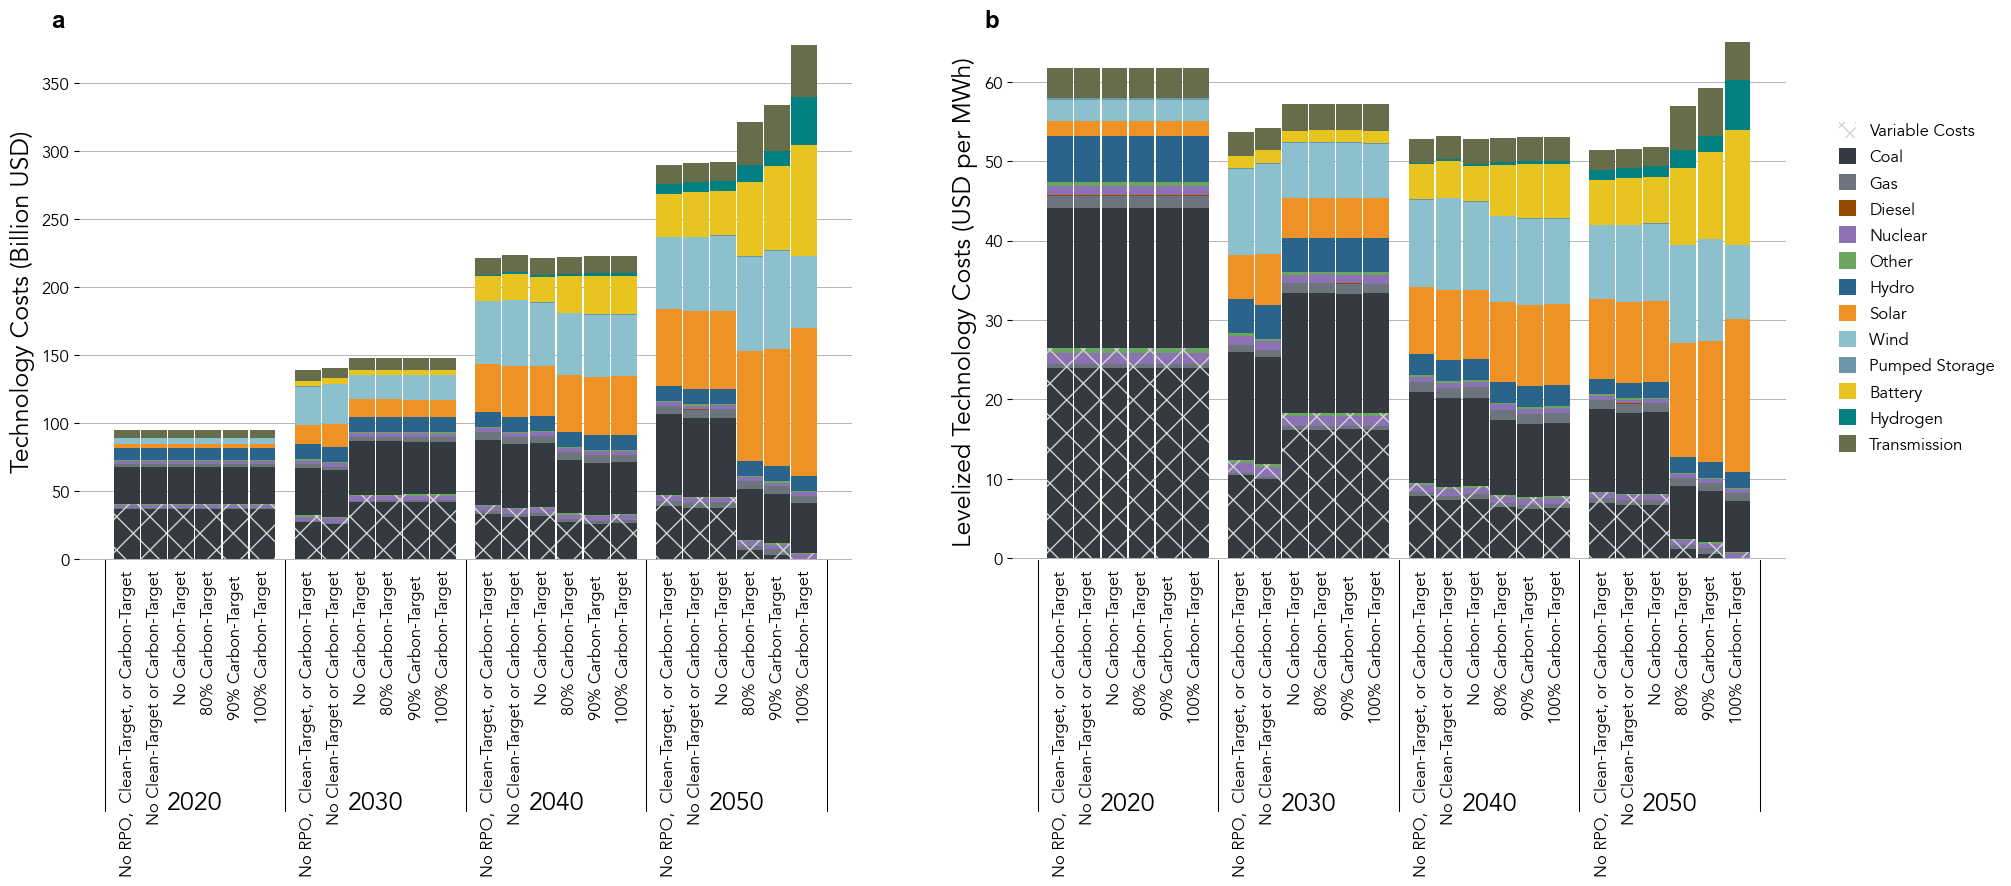

In [129]:
fig, _ax = plt.subplot_mosaic([['a', 'b']], 
                              layout      = 'constrained', 
                              figsize     = (20, 8.75), 
                              gridspec_kw = {'wspace': .1, 
                                             'width_ratios': [1, 1]})

for label, ax in _ax.items():
    ax.text(0.0, 1.0, label, 
            transform = (ax.transAxes + ScaledTranslation(-20/72, +7/72, fig.dpi_scale_trans)),
            fontsize  = 'xx-large', 
            weight    = "bold",
            va        = 'bottom',
            family    = 'Arial')

# Enter a title of your choice between the quotation marks ('') under title = ''.
_plot_total_fixed_and_variable_cost(_ax['a'], policy_iced_['tech_cost'], policy_iced_['scen_labels'], tech_labels_, 
                                    ylabel       = r'Technology Costs (Billion USD)',
                                    y_lim_max    = 380,
                                    y_period_loc = -180,
                                    y_grid_inc   = 50,
                                    div_line_len = 0.485,
                                    legend       = False)
    
# Enter a title of your choice between the quotation marks ('') under title = ''.
_plot_levelized_fixed_and_variable_cost(_ax['b'], policy_iced_['tech_cost'], policy_iced_['demand'], policy_iced_['scen_labels'], tech_labels_, 
                                        ylabel       = r'Levelized Technology Costs (USD per MWh)',
                                        y_lim_max    = 65,
                                        y_period_loc = -31,
                                        y_grid_inc   = 10,
                                        div_line_len = 0.485,
                                        legend       = True)

plt.savefig(path_to_images + '/policy_iced-technology_costs.pdf', 
            bbox_inches = 'tight', 
            dpi         = 600)

plt.savefig(path_to_images + '/policy_iced-technology_costs.png', 
            bbox_inches = 'tight', 
            dpi         = 300)

plt.show()

In [130]:
policy_pier_                = {}
policy_pier_['scen_labels'] = pd.read_csv(path_to_csvs + '/policy_pier-scenario_labels.csv') 
technology_cost_, demand_   = _load_cost(policy_pier_['scen_labels'])
policy_pier_['tech_cost'], policy_pier_['demand'] = _group_tech_cost_by_tech(_group_cost_technologies(technology_cost_, tech_labels_), demand_, policy_pier_['scen_labels'])

policy_pier_['tech_cost'].loc[policy_pier_['tech_cost']['technology'] == 'Transmission Losses', 'fixed_cost'] += 5.9e9

VREmid_STmid_CONVmid_H2_RES_10PRM_CC_PIERmid /Users/Guille/Desktop/india_power/scenarios/policy
VREmid_STmid_CONVmid_H2_RES_10PRM_CC_50RPS_PIERmid /Users/Guille/Desktop/india_power/scenarios/policy
VREmid_STmid_CONVmid_H2_RES_10PRM_CC_50RPS_500GW_PIERmid /Users/Guille/Desktop/india_power/scenarios/policy
VREmid_STmid_CONVmid_H2_RES_10PRM_CC_50RPS_80CAP_500GW_PIERmid /Users/Guille/Desktop/india_power/scenarios/policy
VREmid_STmid_CONVmid_H2_RES_10PRM_CC_50RPS_90CAP_500GW_PIERmid /Users/Guille/Desktop/india_power/scenarios/policy
VREmid_STmid_CONVmid_H2_RES_10PRM_CC_50RPS_100CAP_500GW_PIERmid /Users/Guille/Desktop/india_power/scenarios/policy


VREmid_STmid_CONVmid_H2_RES_10PRM_CC_PIERmid
VREmid_STmid_CONVmid_H2_RES_10PRM_CC_50RPS_PIERmid
VREmid_STmid_CONVmid_H2_RES_10PRM_CC_50RPS_500GW_PIERmid
VREmid_STmid_CONVmid_H2_RES_10PRM_CC_50RPS_80CAP_500GW_PIERmid
VREmid_STmid_CONVmid_H2_RES_10PRM_CC_50RPS_90CAP_500GW_PIERmid
VREmid_STmid_CONVmid_H2_RES_10PRM_CC_50RPS_100CAP_500GW_PIERmid


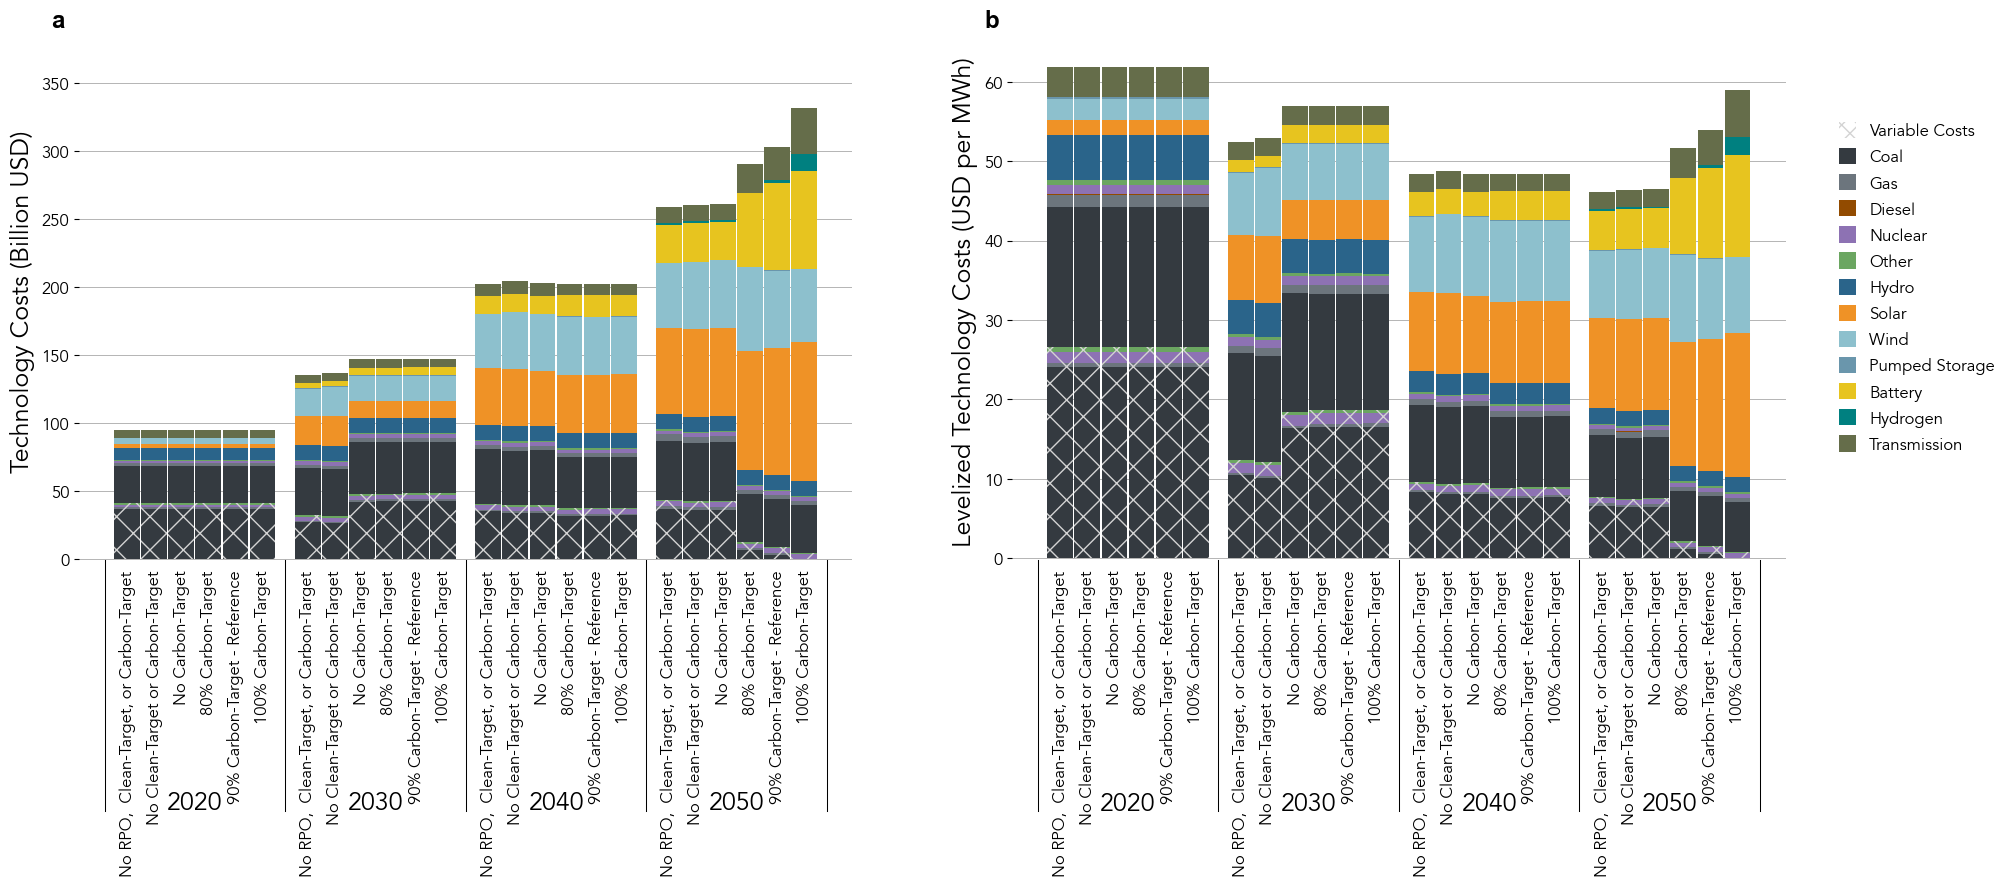

In [131]:
fig, _ax = plt.subplot_mosaic([['a', 'b']], 
                              layout      = 'constrained', 
                              figsize     = (20, 8.75), 
                              gridspec_kw = {'wspace': .1, 
                                             'width_ratios': [1, 1]})
for label, ax in _ax.items():
    ax.text(0.0, 1.0, label, 
            transform = (ax.transAxes + ScaledTranslation(-20/72, +7/72, fig.dpi_scale_trans)),
            fontsize  = 'xx-large', 
            weight    = "bold",
            va        = 'bottom',
            family    = 'Arial')

# Enter a title of your choice between the quotation marks ('') under title = ''.
_plot_total_fixed_and_variable_cost(_ax['a'], policy_pier_['tech_cost'], policy_pier_['scen_labels'], tech_labels_, 
                                    ylabel       = r'Technology Costs (Billion USD)',
                                    yplabel      = r'Technology Costs (Trillion INR)',
                                    y_lim_max    = 380,
                                    y_period_loc = -180,
                                    y_grid_inc   = 50,
                                    div_line_len = 0.485,
                                    legend       = False)
    
# Enter a title of your choice between the quotation marks ('') under title = ''.
_plot_levelized_fixed_and_variable_cost(_ax['b'], policy_pier_['tech_cost'], policy_pier_['demand'], policy_pier_['scen_labels'], tech_labels_, 
                                        ylabel       = r'Levelized Technology Costs (USD per MWh)',
                                        yplabel      = r'Levelized Technology Costs (INR per MWh)',
                                        y_lim_max    = 65,
                                        y_period_loc = -31,
                                        y_grid_inc   = 10,
                                        div_line_len = 0.485,
                                        legend       = True)

plt.savefig(path_to_images + '/policy_pier-technology_costs.pdf', 
            bbox_inches = 'tight', 
            dpi         = 600)

plt.savefig(path_to_images + '/policy_pier-technology_costs.png', 
            bbox_inches = 'tight', 
            dpi         = 300)

plt.show()

In [132]:
demand_profiles_                = {}
demand_profiles_['scen_labels'] = pd.read_csv(path_to_csvs + '/demand_profiles-scenario_labels.csv') 
technology_cost_, demand_       = _load_cost(demand_profiles_['scen_labels'])
demand_profiles_['tech_cost'], demand_profiles_['demand'] = _group_tech_cost_by_tech(_group_cost_technologies(technology_cost_, tech_labels_), demand_, demand_profiles_['scen_labels'])

demand_profiles_['tech_cost'].loc[demand_profiles_['tech_cost']['technology'] == 'Transmission Losses', 'fixed_cost'] += 5.9e9

VREmid_STmid_CONVmid_H2_RES_10PRM_CC_50RPS_90CAP_500GW_ICEDlow /Users/Guille/Desktop/india_power/scenarios/demand
VREmid_STmid_CONVmid_H2_RES_10PRM_CC_50RPS_90CAP_500GW_ICEDmid /Users/Guille/Desktop/india_power/scenarios/demand
VREmid_STmid_CONVmid_H2_RES_10PRM_CC_50RPS_90CAP_500GW_ICEDhigh /Users/Guille/Desktop/india_power/scenarios/demand
VREmid_STmid_CONVmid_H2_RES_10PRM_CC_50RPS_90CAP_500GW_PIERlow /Users/Guille/Desktop/india_power/scenarios/demand
VREmid_STmid_CONVmid_H2_RES_10PRM_CC_50RPS_90CAP_500GW_PIERmid /Users/Guille/Desktop/india_power/scenarios/demand
VREmid_STmid_CONVmid_H2_RES_10PRM_CC_50RPS_90CAP_500GW_PIERhigh /Users/Guille/Desktop/india_power/scenarios/demand


In [1]:
fig, _ax = plt.subplot_mosaic([['A'],
                               ['B']], 
                              layout      = 'constrained', 
                              figsize     = (10, 20), 
                              gridspec_kw = {'width_ratios': [1]})

for label, ax in _ax.items():
    ax.text(0.0, 1.0, label, 
            transform = (ax.transAxes + ScaledTranslation(-20/72, +7/72, fig.dpi_scale_trans)),
            fontsize  = 'xx-large', 
            weight    = "bold",
            va        = 'bottom',
            family    = 'Arial')

# Enter a title of your choice between the quotation marks ('') under title = ''.
_plot_total_fixed_and_variable_cost(_ax['a'], demand_profiles_['tech_cost'], demand_profiles_['scen_labels'], tech_labels_, 
                                    ylabel       = r'Technology Costs (Billion USD)',
                                    yplabel      = r'Technology Costs (Trillion INR)',
                                    y_lim_max    = 400,
                                    y_period_loc = -99,
                                    y_grid_inc   = 50,
                                    div_line_len = 0.255,
                                    legend       = False)
    
# Enter a title of your choice between the quotation marks ('') under title = ''.
_plot_levelized_fixed_and_variable_cost(_ax['b'], demand_profiles_['tech_cost'], demand_profiles_['demand'], demand_profiles_['scen_labels'], tech_labels_, 
                                        ylabel       = r'Levelized Technology Costs (USD per MWh)',
                                        yplabel      = r'Levelized Technology Costs (INR per MWh)',
                                        y_lim_max    = 70,
                                        y_period_loc = -17.5,
                                        y_grid_inc   = 10,
                                        div_line_len = 0.255,
                                        legend       = True)

plt.savefig(path_to_images + '/demand_profiles-technology_costs.pdf', 
            bbox_inches = 'tight', 
            dpi         = 600)

plt.savefig(path_to_images + '/demand_profiles-technology_costs.png', 
            bbox_inches = 'tight', 
            dpi         = 300)

plt.show()

NameError: name 'plt' is not defined

In [134]:
alt_tech_                 = {}
alt_tech_['scen_labels']  = pd.read_csv(path_to_csvs + '/alt_tech-scenario_labels.csv') 
technology_cost_, demand_ = _load_cost(alt_tech_['scen_labels'])
alt_tech_['tech_cost'], alt_tech_['demand'] = _group_tech_cost_by_tech(_group_cost_technologies(technology_cost_, tech_labels_), demand_, alt_tech_['scen_labels'])

alt_tech_['tech_cost'].loc[alt_tech_['tech_cost']['technology'] == 'Transmission Losses', 'fixed_cost'] += 5.9e9

VREmid_STmid_CONVmid_RES_10PRM_CC_50RPS_90CAP_500GW_PIERmid /Users/Guille/Desktop/india_power/scenarios/technology
VREmid_STmid_CONVmid_H2_RES_10PRM_CC_50RPS_90CAP_500GW_PIERmid /Users/Guille/Desktop/india_power/scenarios/technology
VREmid_STmid_CONVmid_PSH_RES_10PRM_CC_50RPS_90CAP_500GW_PIERmid /Users/Guille/Desktop/india_power/scenarios/technology
VREmid_STmid_CONVmid_N_RES_10PRM_CC_50RPS_90CAP_500GW_PIERmid /Users/Guille/Desktop/india_power/scenarios/technology
VREmid_STmid_CONVmid_H2PSH_RES_10PRM_CC_50RPS_90CAP_500GW_PIERmid /Users/Guille/Desktop/india_power/scenarios/technology
VREmid_STmid_CONVmid_H2PSHN_RES_10PRM_CC_50RPS_90CAP_500GW_PIERmid /Users/Guille/Desktop/india_power/scenarios/technology


VREmid_STmid_CONVmid_RES_10PRM_CC_50RPS_90CAP_500GW_PIERmid
VREmid_STmid_CONVmid_H2_RES_10PRM_CC_50RPS_90CAP_500GW_PIERmid
VREmid_STmid_CONVmid_PSH_RES_10PRM_CC_50RPS_90CAP_500GW_PIERmid
VREmid_STmid_CONVmid_N_RES_10PRM_CC_50RPS_90CAP_500GW_PIERmid
VREmid_STmid_CONVmid_H2PSH_RES_10PRM_CC_50RPS_90CAP_500GW_PIERmid
VREmid_STmid_CONVmid_H2PSHN_RES_10PRM_CC_50RPS_90CAP_500GW_PIERmid


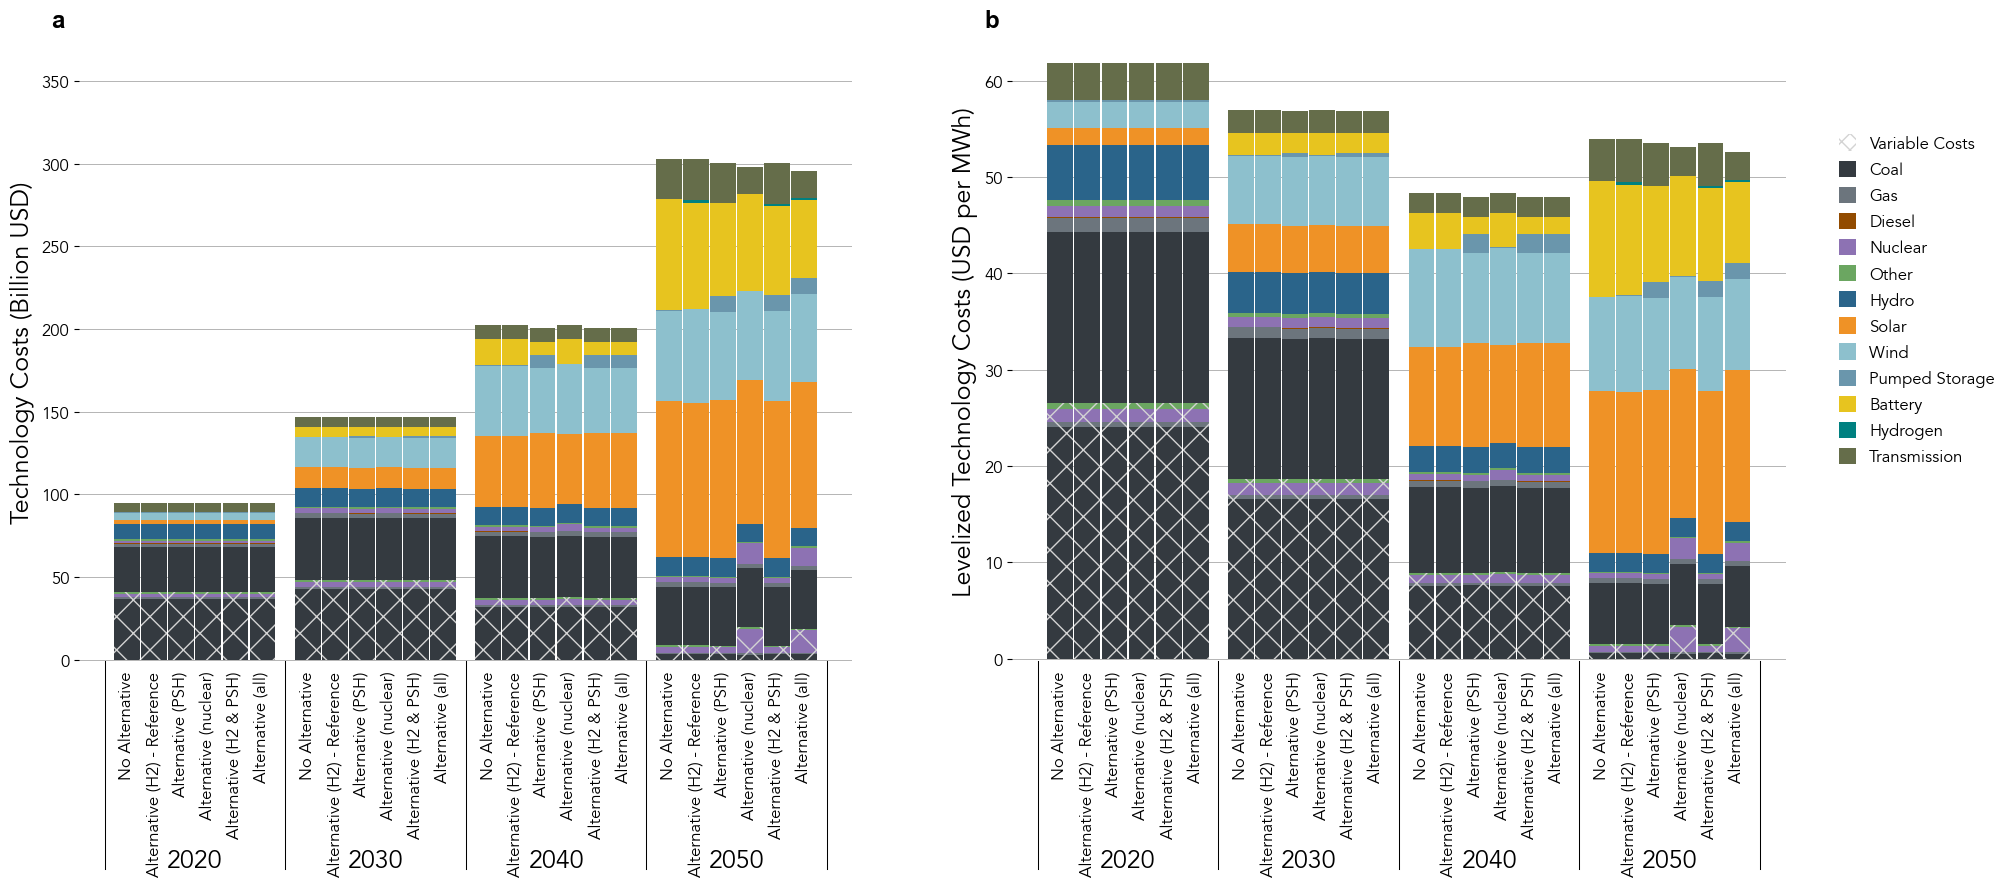

In [135]:
fig, _ax = plt.subplot_mosaic([['a', 'b']], 
                              layout      = 'constrained', 
                              figsize     = (20, 8.75), 
                              gridspec_kw = {'wspace': .1, 
                                             'width_ratios': [1, 1]})

for label, ax in _ax.items():
    ax.text(0.0, 1.0, label, 
            transform = (ax.transAxes + ScaledTranslation(-20/72, +7/72, fig.dpi_scale_trans)),
            fontsize  = 'xx-large', 
            weight    = "bold",
            va        = 'bottom',
            family    = 'Arial')

# Enter a title of your choice between the quotation marks ('') under title = ''.
_plot_total_fixed_and_variable_cost(_ax['a'], alt_tech_['tech_cost'], alt_tech_['scen_labels'], tech_labels_, 
                                    ylabel       = r'Technology Costs (Billion USD)',
                                    yplabel      = r'Technology Costs (Trillion INR)',
                                    y_lim_max    = 373.5,
                                    y_period_loc = -122,
                                    y_grid_inc   = 50,
                                    div_line_len = 0.335,
                                    legend       = False)
    
# Enter a title of your choice between the quotation marks ('') under title = ''.
_plot_levelized_fixed_and_variable_cost(_ax['b'], alt_tech_['tech_cost'], alt_tech_['demand'], alt_tech_['scen_labels'], tech_labels_, 
                                        ylabel       = r'Levelized Technology Costs (USD per MWh)',
                                        yplabel      = r'Levelized Technology Costs (INR per MWh)',
                                        y_lim_max    = 64,
                                        y_period_loc = -21,
                                        y_grid_inc   = 10,
                                        div_line_len = 0.335,
                                        legend       = True)

plt.savefig(path_to_images + '/alt_tech-technology_costs.pdf', 
            bbox_inches = 'tight', 
            dpi         = 600)

plt.savefig(path_to_images + '/alt_tech-technology_costs.png', 
            bbox_inches = 'tight', 
            dpi         = 300)

plt.show()

# Technology Costs

In [ ]:
tech_labels_ = pd.read_csv(path_to_csvs + '/technology_labels.csv') 
scen_labels_ = pd.read_csv(path_to_csvs + '/policy_iced-scenario_labels.csv') 

In [9]:
tech_cost_, demand_                       = _load_cost(scen_labels_)
grouped_tech_cost_                        = _group_cost_technologies(tech_cost_, tech_labels_)
grouped_tech_cost_by_tech_, total_demand_ = _group_tech_cost_by_tech(grouped_tech_cost_, demand_, scen_labels_)

grouped_tech_cost_by_tech_.loc[grouped_tech_cost_by_tech_['technology'] == 'Tx_Losses', 'fixed_cost'] += 5.9e9

VREmid_STmid_CONVmid_H2_RES_10PRM_CC_ICEDmid /Users/Guille/Desktop/india_power/scenarios/policy


KeyboardInterrupt: 

### Levelized Technology Costs

VREmid_STmid_CONVmid_H2_RES_10PRM_CC_50RPS_ICEDmid
VREmid_STmid_CONVmid_H2_RES_10PRM_CC_50RPS_500GW_ICEDmid
VREmid_STmid_CONVmid_H2_RES_10PRM_CC_50RPS_80CAP_500GW_ICEDmid
VREmid_STmid_CONVmid_H2_RES_10PRM_CC_50RPS_90CAP_500GW_ICEDmid
VREmid_STmid_CONVmid_H2_RES_10PRM_CC_50RPS_100CAP_500GW_ICEDmid


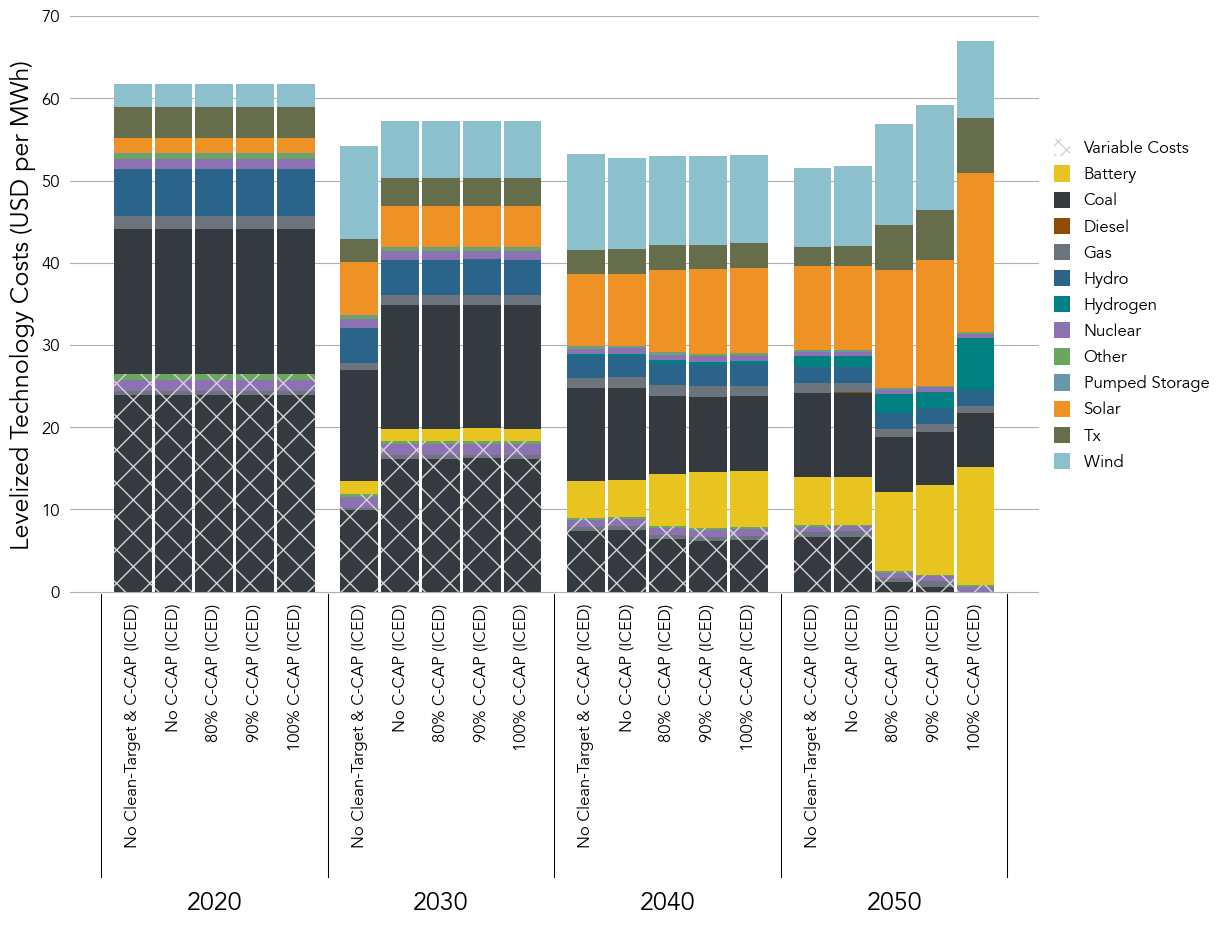

In [12]:
fig = plt.figure(figsize = (12.5, 7.5))
_ax = plt.subplot(111)
    
# Enter a title of your choice between the quotation marks ('') under title = ''.
_plot_levelized_fixed_and_variable_cost(_ax, grouped_tech_cost_by_tech_, total_demand_,
                                        scen_labels_, tech_labels_, 
                                        units_label = r'Levelized Technology Costs (USD per MWh)')

plt.savefig(path_to_images + r'/levelized_fixed_and_variable_costs.png', 
            bbox_inches = 'tight',
            dpi         = 600)

plt.show()

### Total Technology Costs

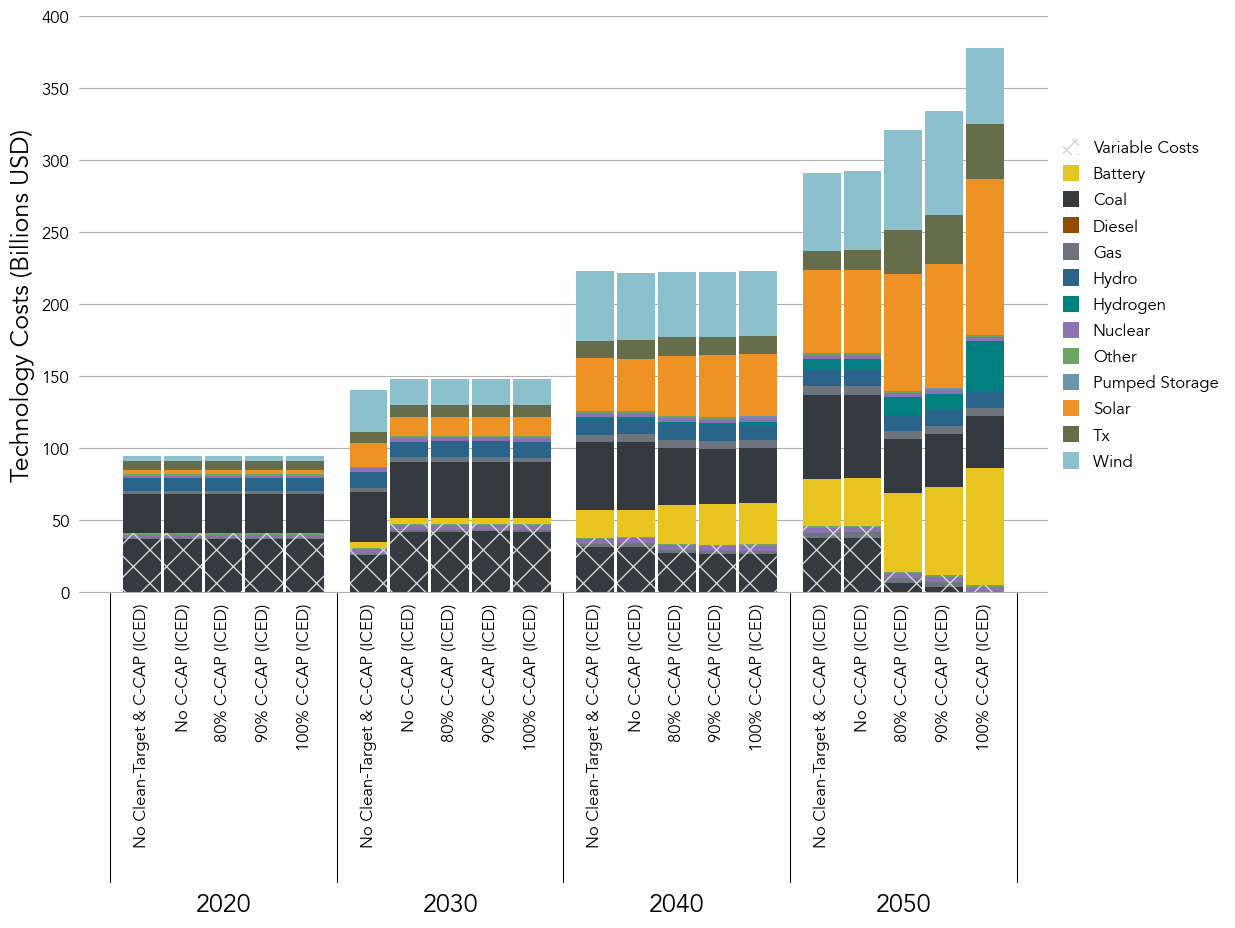

In [11]:
fig = plt.figure(figsize = (12.5, 7.5))
_ax = plt.subplot(111)
    
# Enter a title of your choice between the quotation marks ('') under title = ''.
_plot_total_fixed_and_variable_cost(_ax, grouped_tech_cost_by_tech_,
                                    scen_labels_, tech_labels_, 
                                    units_label  = r'Technology Costs (Billions USD)')

plt.savefig(path_to_images + r'/fixed_and_variable_costs.png', 
            bbox_inches = 'tight',
            dpi         = 600)

plt.show()